# QURI SDK workshop

This notebook is for training in use of QURI SDK. It includes training on

- Using QURI Parts for circuit definitions and sampling
- Using QURI VM to define virtual machines for resource estimation and analysis
- Using QURI Algo to run predefined quantum algorithms
- Circuit synthesis using qsub


Each section contains exercise to test your understanding, please try to complete all of them.

## Prerequisites

To use this notebook, the following libraries are required. Please run the cell below to set up your environment.
- quri-parts-circuit: 0.22.0
- quri-parts-core: 0.22.0
- quri-parts-qulacs: 0.22.0
- quri-parts-rust: 0.22.0
- quri-algo: 0.1.2
- quri-vm: 0.1.0

In [ ]:
import subprocess
import sys
from importlib.metadata import version as get_dist_version, PackageNotFoundError

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def check_and_install(package, required_version, auto_install=False):
    try:
        installed_version = get_dist_version(package)
        if installed_version != required_version:
            print(f"⚠️ Version mismatch for {package}.")
            print(f"    Installed: {installed_version}, Required: {required_version}")
            print("    Please consider aligning the version manually if necessary.")
        else:
            print(f"✅ {package} version is as expected ({installed_version})")
    except PackageNotFoundError:
        print(f"❌ {package} is not installed.")
        if auto_install or is_colab():
            print(f"📦 Installing {package}=={required_version} ...")
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package}=={required_version}"])
                print(f"✅ {package} installation completed successfully.")
            except subprocess.CalledProcessError:
                print(f"❌ Failed to install {package}.")
        else:
            user_input = input(f"Do you want to install {package}=={required_version}? [y/N]: ")
            if user_input.lower() == 'y':
                print(f"📦 Installing {package} ...")
                try:
                    subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package}=={required_version}"])
                    print(f"✅ {package} installation completed successfully.")
                except subprocess.CalledProcessError:
                    print(f"❌ Failed to install {package}.")
            else:
                print(f"⏭️ Skipped installation of {package}.")


qp_packages = ["qulacs", "qsub"]
for package in qp_packages:
  check_and_install("quri-parts." + package, "0.22.0")

check_and_install("quri-algo", "0.1.2")
check_and_install("quri-vm", "0.1.2")

## QURI Parts basics

In this section we will introduce some basic QURI Parts code for circuit definition. In this section you will learn

- How to define circuits in quri parts
- Manipulations you can perform on circuits
- How to define parametric circuits
- How to use predefined ansatze
- How to use samplers and estimators

### Quantum circuits

First, let's define a basic circuit. For this we need to import `QuantumCircuit`

In [1]:
from quri_parts.circuit import QuantumCircuit

qubit_count = 2

circuit = QuantumCircuit(qubit_count)  # create an empty quantum circuit with 2 qubits
circuit.add_H_gate(0)  # Add Hadamard gate on 0'th qubit
circuit.add_CNOT_gate(0,1)

circuit.draw()

   ___          
  | H |         
--|0  |-----●---
  |___|     |   
           _|_  
          |CX | 
----------|1  |-
          |___| 


As seen above, the `QuantumCircuit` object has its own methods to add quantum gates. We can also instantiate a `QuantumCircuit` directly from a sequence of gates

In [2]:
from quri_parts.circuit.gates import H, CNOT
circuit_variant = QuantumCircuit(qubit_count, gates=[H(0), CNOT(0, 1)])

print(circuit == circuit_variant)  # True

True


We can also add circuits

In [3]:
circuit_sum = QuantumCircuit(qubit_count, gates=[H(0)]) + QuantumCircuit(qubit_count, gates=[CNOT(0, 1)])

print(circuit == circuit_sum)  # True

True


In order to sample this circuit, we can use its sample method

In [4]:
circuit.sample(1000)  # Sample the circuit 1000 times

Counter({3: 513, 0: 487})

This returns a mapping from the sampled bitstring to the number of samples resulting from the sampling experiment. The above method uses a default sampler that does not take noise into account, but draws samples from a multinomial distribution depending on the probability amplitudes of each logical state.

### Exercise 0

With what you have learned above, now try to define your own circuit that generates the following state

$|\psi> = \frac{1}{\sqrt{2}} (|01> + |10>)$

Confirm that you got it right by
- Drawing the circuit
- Sampling it and comparing with your expectations
- You can solve this problem by summing `circuit` defined above with another quantum circuit that contains only one gate. Which gate is that? And does it matter what qubit it is applied to? Test your intuition on this

### Parametric quantum circuits

Here we will introduce `ParametricQuantumCircuit`. These are circuits that can be updated with parameters which map to gate angles. For this, one needs to add parametric gates.

In [5]:
from quri_parts.circuit import ParametricQuantumCircuit

parametric_circuit = ParametricQuantumCircuit(2)
parametric_circuit.add_H_gate(0)
parametric_circuit.add_CNOT_gate(0, 1)
p_theta = parametric_circuit.add_ParametricRX_gate(0)
p_phi = parametric_circuit.add_ParametricRY_gate(0)
p_psi = parametric_circuit.add_ParametricRZ_gate(1)

parametric_circuit.draw()

   ___             ___     ___  
  | H |           |PRX|   |PRY| 
--|0  |-----●-----|2  |---|3  |-
  |___|     |     |___|   |___| 
           _|_     ___          
          |CX |   |PRZ|         
----------|1  |---|4  |---------
          |___|   |___|         


We can get the parameter count

In [6]:
print("Number of parameters in the circuit:", parametric_circuit.parameter_count)

Number of parameters in the circuit: 3


And then we can bind the parameters to concrete angles for their values. This returns an `ImmutableBoundParametricQuantumCircuit` object. Just like regular quantum circuits, these can be sampled

In [7]:
bound_circuit = parametric_circuit.bind_parameters([0.1, 0.2, 0.3])
bound_circuit.sample(1000)

Counter({3: 504, 0: 488, 1: 4, 2: 4})

However, with parametric circuits we can also sample them without binding the parameters. We just have to provide the parameters when calling the sample method.

In [8]:
parametric_circuit.sample(1000, [0.1, 0.2, 0.3])

Counter({0: 507, 3: 476, 1: 9, 2: 8})

By default, parametric circuits that have been defined in this way have a trivial parameter mapping, since each parameter corresponds directly to a quantum gate.

In [9]:
parametric_circuit.has_trivial_parameter_mapping

True

However we can also imagine adding a linear parameter mapping, which is done using the `LinearMappedUnboundParametricQuantumCircuit`

In [10]:
import numpy as np
from quri_parts.circuit import LinearMappedUnboundParametricQuantumCircuit, CONST

linear_param_circuit = LinearMappedUnboundParametricQuantumCircuit(2)
theta, phi = linear_param_circuit.add_parameters("theta", "phi")

linear_param_circuit.add_H_gate(0)
linear_param_circuit.add_CNOT_gate(0, 1)
linear_param_circuit.add_ParametricRX_gate(0, {theta: 1/2, phi: 1/3, CONST: np.pi/2})
linear_param_circuit.add_ParametricRY_gate(0, {theta: -1/2, phi: 1/3})
linear_param_circuit.add_ParametricRZ_gate(1, {theta: 1/3, phi: -1/2, CONST: -np.pi/2})

Notice that the workflow differs slightly, as we have to define the parameters beforehand and then add them when adding the parametric circuits. Each parameter represents a term in a linear equation with a coefficient, which is mapped to in the second argument to the parametric gate. There is also a `CONST` which just represent constant terms.

We can inspect the mapping of the parameters to gate angles by looking at the parameter mapping

In [11]:
from pprint import pprint

pprint(linear_param_circuit.param_mapping.mapping)

{Parameter(name=): mappingproxy({Parameter(name=): -1.5707963267948966,
                                 Parameter(name=phi): -0.5,
                                 Parameter(name=theta): 0.3333333333333333}),
 Parameter(name=): mappingproxy({Parameter(name=phi): 0.3333333333333333,
                                 Parameter(name=theta): -0.5}),
 Parameter(name=): mappingproxy({Parameter(name=): 1.5707963267948966,
                                 Parameter(name=phi): 0.3333333333333333,
                                 Parameter(name=theta): 0.5})}


Each key is a parameter that is directly applied to a quantum gate, and the values contain mappingproxy objects, which represent linear equations used to calculate those angles. You can carry out this calculation directly to obtain the gate angles for some set of parameters by calling a mapper

In [12]:
linear_param_circuit.param_mapping.mapper({theta: 0.8, phi: 0.7})

{Parameter(name=): 2.20412966012823,
 Parameter(name=): -0.1666666666666667,
 Parameter(name=): -1.6541296601282298}

Binding parameters produces an `ImmutableBoundParametricQuantumCircuit`, in the same way as with ParametricQuantumCircuit.

In [13]:
# linear_param_circuit.bind_parameters([0.8, 0.7])
linear_param_circuit.bind_parameters_by_dict({theta: 0.8, phi: 0.7})

### Exercise 1

Based on what you have learned here, write code that can perform time-evolution on a 4-qubit quantum state generated by the Hamiltonian

$H = \sum_{i=0}^{3} c_i Z_i $

Where the coefficients are $\mathbf{c} = [0.4,1.6,0.8,1.0]$. Your result should be a parametric quantum circuit that takes one parameter, `time`, as an input. Set $\hbar = 1$

## QURI VM basics

In this section we will introduce QURI VM and its usage. You will learn

- How to define a virtual machine
- How to analyze quantum circuits
- What predefined architectures are available

### Virtual machines

We use the `VM` class to define virtual machines. This can be done as

In [14]:
from quri_vm import VM
from quri_parts.backend.devices import clifford_t_device
from quri_parts.backend.units import TimeUnit, TimeValue

physical_error_rate=1.0e-5
d=7
qec_cycle_us=1.0
delta_sk=1.0e-5
mode_block="compact"

clifford_t_device_property = clifford_t_device.generate_device_property(
        qubit_count=qubit_count,
        code_distance=d,
        qec_cycle=TimeValue(qec_cycle_us, TimeUnit.MICROSECOND),
        delta_sk=delta_sk,
        physical_error_rate=physical_error_rate,
        mode_block=mode_block
    )

vm = VM.from_device_prop(clifford_t_device_property)

The VM defined above is a Clifford+T device. It has the capability to do resource estimates based on the surface code using the Clifford+T decomposition. The above parameters can be changed based on the specifics of the device and they correspond to standard parameters in the surface code.

We can use virtual machines to sample quantum circuits, as they provide their own samplers

In [15]:
circuit = QuantumCircuit(qubit_count, gates=[H(0), CNOT(0, 1)])

vm.sample(circuit, shots=1000)

Counter({0: 509, 3: 491})

or analyze a quantum circuit

In [16]:
pprint(vm.analyze(circuit))

AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=2,
              gate_count=2,
              depth=2,
              latency=TimeValue(value=35000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.999999994290949)


This gives us information about various circuit characteristics including the latency, fidelity etc. This therefore has the capability to do resource estimates for quantum algorithms of interest.

Aside from the Clifford+T architecture, trapped ion and superconducting NISQ architectures as well as the partially fault tolerant STAR architecture are also available. To use those, the have to be initialized through a device property.

In [ ]:
from quri_parts.backend.devices import nisq_iontrap_device, nisq_spcond_lattice, star_device
from quri_parts.circuit.topology import SquareLattice

nisq_iontrap_vm = VM.from_device_prop(
    nisq_iontrap_device.generate_device_property(
        qubit_count=4,
        native_gates_1q=("RZ", "SqrtX", "X"),
        native_gates_2q=("CNOT",),
        gate_error_1q=1.53e-3,
        gate_error_2q=4e-2,
        gate_error_meas=2.5e-3,
        gate_time_1q=TimeValue(10, TimeUnit.MICROSECOND),
        gate_time_2q=TimeValue(200, TimeUnit.MICROSECOND),
        gate_time_meas=TimeValue(130, TimeUnit.MICROSECOND),
    )
)
nisq_spcond_vm = VM.from_device_prop(
    nisq_spcond_lattice.generate_device_property(
        lattice=SquareLattice(2, 2),  # Has to be associated with a device topology
        native_gates_1q=("RZ", "SqrtX", "X"),
        native_gates_2q=("CNOT",),
        gate_error_1q=1e-3,
        gate_error_2q=1e-2,
        gate_error_meas=1e-2,
        gate_time_1q=TimeValue(60, TimeUnit.NANOSECOND),
        gate_time_2q=TimeValue(660, TimeUnit.NANOSECOND),
        gate_time_meas=TimeValue(1.4, TimeUnit.MICROSECOND),
    )
)
star_vm = VM.from_device_prop(
    star_device.generate_device_property(
        qubit_count=4,
        code_distance=7,
        qec_cycle=TimeValue(value=1.0, unit=TimeUnit.MICROSECOND),
        physical_error_rate=1e-4
    )
)

With this in mind, we can compare the above devices.

### Exercise 2

Using the star_vm defined above with physical error rate $10^{-4}$, write some code to generate a circuit, then analyze your own circuit and note what the fidelity is.

Now compare to the result you get when using any of the NISQ devices. Try tuning the parameters of a NISQ device until you obtain one that can compete with the STAR devices fidelity. What parameters did you get?

## QURI Algo basics

In this section we will introduce some algorithm components from QURI Algo. Among these are

- Time evolution operators
- Cost function
- Algorithms

### Generating time-evolution with circuit factories

QURI Algo introduces circuit factories that can generate complex circuits such as time-evolution circuits, etc. We can use these to generate time-evolution circuits any generic qubit Hamiltonian

In [18]:
from quri_parts.core.operator import Operator, pauli_label

from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterTimeEvolutionCircuitFactory
from quri_algo.problem import QubitHamiltonian

N_TROTTER=2
EVOLUTION_TIME=0.1
QUBIT_COUNT=4

# Hamiltonian operator
hamiltonian = Operator()
hamiltonian.add_term(pauli_label("X0 X1"), 1.0)
hamiltonian.add_term(pauli_label("X1 X2"), 1.0)
hamiltonian.add_term(pauli_label("X2 X3"), 1.0)
hamiltonian.add_term(pauli_label("X3 X0"), 1.0)
hamiltonian.add_term(pauli_label("Z0"), -1.0)
hamiltonian.add_term(pauli_label("Z1"), -1.0)
hamiltonian.add_term(pauli_label("Z2"), -1.0)
hamiltonian.add_term(pauli_label("Z3"), -1.0)

# Input for quantum algorithms
hamiltonian_input = QubitHamiltonian(QUBIT_COUNT, hamiltonian)

# Time evolution operator
time_evo_circuit_factory = TrotterTimeEvolutionCircuitFactory(hamiltonian_input, n_trotter=N_TROTTER)

time_evo_circuit = time_evo_circuit_factory(EVOLUTION_TIME)  # generate time evolution circuit and draw it
time_evo_circuit.draw()

   ___                     ___             ___     ___                     ___  
  |PR |                   |PR |           |PR |   |PR |                   |PR | 
--|0  |-------------------|3  |-----------|4  |---|8  |-------------------|11 |-
  |   |                   |_ _|           |___|   |   |                   |_ _| 
  |   |    ___     ___     | |                    |   |    ___     ___     | |  
  |   |   |PR |   |PR |    | |                    |   |   |PR |   |PR |    | |  
--|   |---|1  |---|5  |----| |--------------------|   |---|9  |---|13 |----| |--
  |___|   |   |   |___|    | |                    |___|   |   |   |___|    | |  
          |   |    ___     | |    ___                     |   |    ___     | |  
          |   |   |PR |    | |   |PR |                    |   |   |PR |    | |  
----------|   |---|2  |----| |---|6  |--------------------|   |---|10 |----| |--
          |___|   |   |    | |   |___|                    |___|   |   |    | |  
                  |   |   _|

The above circuit contains Pauli rotations, which are denoted generically by `PR`. These are abstract quantum gates, which represent operations like two-qubit or single qubit Pauli rotations, however, in reality they have to be facilitated by a set of gates native to the device of interest. We can use transpilers for this purpose. Each VM comes with its own transpiler, so let's try to use one and see what the result is

In [19]:
star_vm = VM.from_device_prop(
    star_device.generate_device_property(
        qubit_count=4,
        code_distance=7,
        qec_cycle=TimeValue(value=1.0, unit=TimeUnit.MICROSECOND),
        physical_error_rate=1e-4
    )
)
N_SHOTS = 1000

transpiled_circuit = star_vm.transpile(time_evo_circuit)
transpiled_circuit.draw()

   ___     ___     ___     ___     ___     ___                                  
  | H |   |CX |   |RZ |   |CX |   | H |   | H |                                 
--|0  |---|2  |---|3  |---|4  |---|5  |---|22 |---------------------------------
  |___|   |___|   |___|   |___|   |___|   |___|                                 
   ___      |               |      ___     ___     ___     ___     ___     ___  
  | H |     |               |     | H |   | H |   |CX |   |RZ |   |CX |   | H | 
--|1  |-----●---------------●-----|6  |---|7  |---|9  |---|10 |---|11 |---|12 |-
  |___|                           |___|   |___|   |___|   |___|   |___|   |___| 
   ___                                              |               |      ___  
  | H |                                             |               |     | H | 
--|8  |---------------------------------------------●---------------●-----|13 |-
  |___|                                                                   |___| 
   ___                      

And we can compare their depth

In [20]:
print("Depth of abstract circuit: ", time_evo_circuit.depth)
print("Depth of star vm transpiled circuit: ", transpiled_circuit.depth)

Depth of abstract circuit:  10
Depth of star vm transpiled circuit:  42


### Exercise 3

Considering the above, let's try a different Hamiltonian

In [21]:
three_qubit_hamiltonian = Operator()
three_qubit_hamiltonian.add_term(pauli_label("X0 X1 X2"), 1.0)
three_qubit_hamiltonian.add_term(pauli_label("X1 X2 X3"), 1.0)
three_qubit_hamiltonian.add_term(pauli_label("X2 X3 X0"), 1.0)
three_qubit_hamiltonian.add_term(pauli_label("X3 X0 X1"), 1.0)
three_qubit_hamiltonian.add_term(pauli_label("Z0"), -1.0)
three_qubit_hamiltonian.add_term(pauli_label("Z1"), -1.0)
three_qubit_hamiltonian.add_term(pauli_label("Z2"), -1.0)
three_qubit_hamiltonian.add_term(pauli_label("Z3"), -1.0)

Using the above Hamiltonian, answer the following questions
- What is the depth of the abstract and the transpiled time-evolution circuit for the same number of Trotter steps as was used previously?
- Can you explain the difference in depth between the transpiled time-evolution circuit for the 2-qubit interacting Hamiltonian and the 3-qubit one?
- What is the rule of thumb for how Pauli-rotations are converted into gates?

Note, try not to overwrite previously defined variables because we will use them later.

### Compiling time-evolution circuits

QURI Algo comes with algorithms that can be used easily for various purposes. Here we will introduce quantum assisted quantum compiling (QAQC). This is a variational algorithm that optimizes a trial circuit until it can replicate the unitary action of a target circuit. It does so by updating the circuit parameters and evaluating a cost function that determines how close the circuits are to performing the same unitary operation on the quantum register.

Using the QAQC algorithm, we can compress time-evolution circuits. We do so by defining an ansatz circuit, which is a linearly mapped parametric quantum circuit, just like the ones we've used before. Then we instantiate the algorithm itself and run it to get the compilation result.

In [22]:
from quri_parts.algo.ansatz import Z2SymmetryPreservingReal

from quri_algo.algo.compiler import QAQC

REPS=10

ansatz=Z2SymmetryPreservingReal(qubit_count,reps=REPS)
qaqc=QAQC()

compilation_result = qaqc.run(time_evo_circuit_factory,ansatz,evolution_time=EVOLUTION_TIME)

This algorithm uses the Hilbert-Schmidt test to evaluate how closely the compressed circuit is to the target circuit. We can plot the cost history too

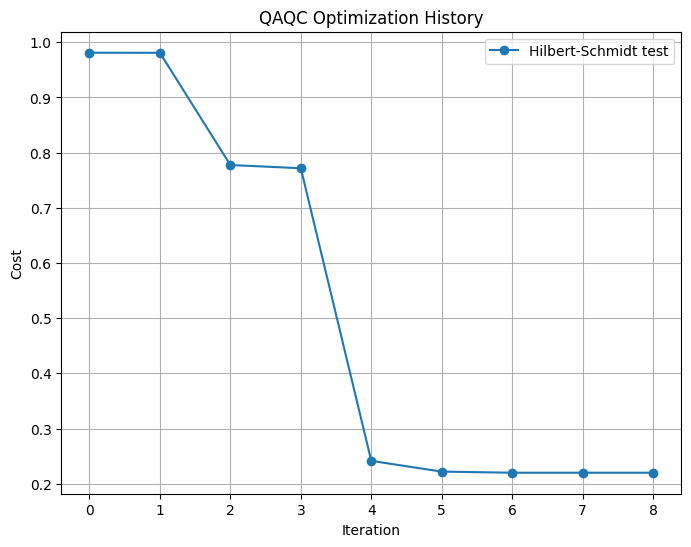

In [42]:
import matplotlib.pyplot as plt

# Assuming compilation_result contains some metrics to plot
# Extracting example data (replace with actual data from compilation_result)
iterations = range(len(compilation_result.cost_function_history[1:]))
costs = compilation_result.cost_function_history[1:]

# Plotting the cost history
plt.figure(figsize=(8, 6))
plt.plot(iterations, costs, marker='o', label='Hilbert-Schmidt test')
plt.title('QAQC Optimization History')
plt.xlabel('Iteration')
plt.xticks(iterations)
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

We can easily analyze the runtime of the algorithm on a real device too

In [24]:
analysis = qaqc.analyze(time_evo_circuit_factory, ansatz, compilation_result, star_vm.analyze, N_SHOTS, evolution_time=0.1)

print(f"Algorithm runtime: {analysis.total_latency.in_ns()*1e-9/3600} h, minimum fidelity: {min(analysis.circuit_fidelities.values())}")

Algorithm runtime: 8.590069444444445 h, minimum fidelity: 0.99623500350332


### Exercise 5

In the above, we used a parity preserving ansatz. Try redoing the circuit compilation with the `SymmetryPreservingReal` and `HardwareEfficientReal` ansatze and compare. In each case answer the question

- Did the algorithm converge to a better or worse cost-function value?
- Why?

## QSUB basics

In this section we will introduce qsub - the quantum circuit synthesis library. You will learn how to

- Write subroutines in qsub
- Convert subroutines to quri parts circuits

### `Op` and `Sub`

In Sub a circuit is represented as a `Sub` (subroutine) object. A `Sub` is defined as a sequence of operations on qubits and classical registers.

The most basic thing you can do is to define a `Sub` using predefined `Op`s.

In [25]:
from quri_parts.qsub.sub import SubBuilder

# Predefined Ops
from quri_parts.qsub.lib.std import H, CNOT, RZ

# Build a circuit for 2 qubits
b = SubBuilder(2)
q0, q1 = b.qubits
b.add_op(H, (q1,))
b.add_op(CNOT, (q0, q1))
b.add_op(RZ(-0.5), (q1,))
b.add_op(CNOT, (q0, q1))
b.add_op(RZ(0.5), (q1,))
b.add_op(H, (q1,))
sub = b.build()

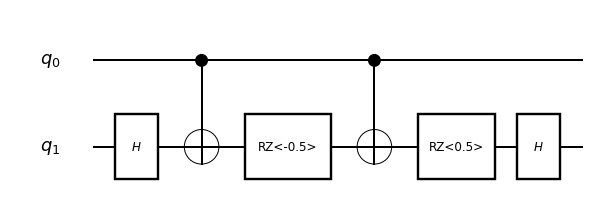

In [26]:
from quri_parts.qsub.visualize import draw_sub

draw_sub(sub)

Some `Op`s are parametric: in the above example, `RZ` is a parametric `Op`. It is just a function returning a (non-parametric) `Op`: `RZ(0.5)` is an `Op` with the fixed parameter 0.5.

### Standard predefined `Op`s: `qsub.lib.std`

`qsub.lib.std` package contains the following standard pre-defined `Op`s.

In [27]:
from math import pi
from quri_parts.qsub.lib import std

print("Single qubit non-parametric gates:")
for op in [
    std.X,
    std.Y,
    std.Z,
    std.H,
    std.SqrtX,
    std.SqrtXdag,
    std.SqrtY,
    std.SqrtYdag,
    std.S,
    std.Sdag,
    std.T,
    std.Tdag,
]:
    print(" ", op)

print("Single qubit parametric rotation gates:")
for op in [
    std.RX,
    std.RY,
    std.RZ,
    std.Phase,
]:
    print(" ", op(pi/8))

print("Two qubit non-parametric gates:")
for op in [
    std.CNOT,
    std.CZ,
    std.SWAP,
]:
    print(" ", op)

print("Three qubit non-parametric gates:")
print(" ", std.Toffoli)

print("Measurement:")
print(" ", std.M)

print("Classical conditional branching:")
for op in [
    std.Cbz,
    std.Label,
]:
    print(" ", op)


_ = [

    "conditional",

    "Inverse",
    "Controlled",
    "MultiControlled",
    "scoped_and",
    "scoped_and_clifford_t",
]


Single qubit non-parametric gates:
  lib.std.X(qubits=1, registers=0)
  lib.std.Y(qubits=1, registers=0)
  lib.std.Z(qubits=1, registers=0)
  lib.std.H(qubits=1, registers=0)
  lib.std.SqrtX(qubits=1, registers=0)
  lib.std.SqrtXdag(qubits=1, registers=0)
  lib.std.SqrtY(qubits=1, registers=0)
  lib.std.SqrtYdag(qubits=1, registers=0)
  lib.std.S(qubits=1, registers=0)
  lib.std.Sdag(qubits=1, registers=0)
  lib.std.T(qubits=1, registers=0)
  lib.std.Tdag(qubits=1, registers=0)
Single qubit parametric rotation gates:
  lib.std.RX<0.39269908169872414>(qubits=1, registers=0)
  lib.std.RY<0.39269908169872414>(qubits=1, registers=0)
  lib.std.RZ<0.39269908169872414>(qubits=1, registers=0)
  lib.std.Phase<0.39269908169872414>(qubits=1, registers=0)
Two qubit non-parametric gates:
  lib.std.CNOT(qubits=2, registers=0)
  lib.std.CZ(qubits=2, registers=0)
  lib.std.SWAP(qubits=2, registers=0)
Three qubit non-parametric gates:
  lib.std.Toffoli(qubits=3, registers=0)
Measurement:
  lib.std.M(qu

There are some parametric `Op`s that take another `Op` as their argument.

### Inverse

`Inverse` returns inverse of a given unitary operation.

In [28]:
from quri_parts.qsub.lib import std

invS = std.Inverse(std.S)
print(invS)

lib.std.Inverse<lib.std.S>(qubits=1, registers=0)


### Controlled

`Controlled` represents a controlled operation of a given unitary operation. If the given unitary is $n$-qubit operation, then the returned controlled operation is $n+1$-qubit operation; The first qubit is the control qubit.

In [29]:
from quri_parts.qsub.lib import std

ctrlS = std.Controlled(std.S)
print(ctrlS)

ctrlToffoli = std.Controlled(std.Toffoli)
print(ctrlToffoli)

lib.std.Controlled<lib.std.S>(qubits=2, registers=0)
lib.std.Controlled<lib.std.Toffoli>(qubits=4, registers=0)


### MultiControlled

`MultiControlled` represents a multi-bit controlled operation of a given unitary operation. It takes three arguments: the target unitary `Op`, number of control bits (int) and control value (int). The control value is interpreted by binary representation: e.g. if `control_value=0b10100`, it is interpreted as `bit0=0`, `bit1=0`, `bit2=1`, `bit3=0` and `bit4=1`.

In [30]:
from quri_parts.qsub.lib import std

mctrlS = std.MultiControlled(std.S, 3, 0b010)
print(mctrlS)

lib.std.MultiControlled<lib.std.S, 3, 2>(qubits=4, registers=0)


### Resolving `Op` to `Sub`

An `Op` itself is just an abstract symbol. Eventually it needs to be resolved as either a primitive (native gate) or a `Sub`. How each `Op` should be resolved can be registered to a `SubRepository`, though users usually don't need to be aware of it since we provide a *default* `SubRepository`. In order to get a `Sub` corresponding to an `Op`, you can use `resolve_sub()` function. If no correspondence is registered for the given `Op`, it returns `None`:

In [31]:
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.lib import std

subS = resolve_sub(std.S)
print(subS)

None


Most operations in `qsub.lib.std` are usually treated as primitives, so no correspondence for them is registered by default.

### Exercise 6

Often controlled time-evolution is needed in quantum algorithms that perform ground state energy estimation (GSEE). For this exercise, we return to the Hamiltonian

$H = \sum_{i=0}^{3} c_i Z_i $

Where the coefficients are $\mathbf{c} = [0.4,1.6,0.8,1.0]$. In Exercise 1 you implemented the time-evolution operator in a quri-parts circuit. This time implement the *controlled* version. Let the first qubit be the control for the time-evolution and set the time to some constant value when implementing the time-evolution. Then

confirm that you get it right by drawing the circuit.

HINT: You can add controlled ops in the same way you add any other ops.

### Resolving Inverse

Correspondences for `Inverse` of standard operations are registered by default.

In [32]:
from math import pi
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.lib import std

print("Single qubit non-parametric gates:")
for op in [
    std.X,
    std.Y,
    std.Z,
    std.H,
    std.SqrtX,
    std.SqrtXdag,
    std.SqrtY,
    std.SqrtYdag,
    std.S,
    std.Sdag,
    std.T,
    std.Tdag,
]:
    inv = std.Inverse(op)
    inv_sub = resolve_sub(inv)
    print(f" Inverse({op.base_id[1]}): {inv_sub}")

print("Single qubit parametric rotation gates:")
for op in [
    std.RX,
    std.RY,
    std.RZ,
    std.Phase,
]:
    inv = std.Inverse(op(pi/8))
    inv_sub = resolve_sub(inv)
    print(f" Inverse({op.base_id[1]}(pi/8)): {inv_sub}")

print("Two qubit non-parametric gates:")
for op in [
    std.CNOT,
    std.CZ,
    std.SWAP,
]:
    inv = std.Inverse(op)
    inv_sub = resolve_sub(inv)
    print(f" Inverse({op.base_id[1]}): {inv_sub}")

print("Three qubit non-parametric gates:")
inv = std.Inverse(std.Toffoli)
inv_sub = resolve_sub(inv)
print(f" Inverse({std.Toffoli.base_id[1]}): {inv_sub}")

Single qubit non-parametric gates:
 Inverse(X): Sub[lib.std.X(q0)]
 Inverse(Y): Sub[lib.std.Y(q0)]
 Inverse(Z): Sub[lib.std.Z(q0)]
 Inverse(H): Sub[lib.std.H(q0)]
 Inverse(SqrtX): Sub[lib.std.SqrtXdag(q0)]
 Inverse(SqrtXdag): Sub[lib.std.SqrtX(q0)]
 Inverse(SqrtY): Sub[lib.std.SqrtYdag(q0)]
 Inverse(SqrtYdag): Sub[lib.std.SqrtY(q0)]
 Inverse(S): Sub[lib.std.Sdag(q0)]
 Inverse(Sdag): Sub[lib.std.S(q0)]
 Inverse(T): Sub[lib.std.Tdag(q0)]
 Inverse(Tdag): Sub[lib.std.T(q0)]
Single qubit parametric rotation gates:
 Inverse(RX(pi/8)): Sub[lib.std.RX<-0.39269908169872414>(q0)]
 Inverse(RY(pi/8)): Sub[lib.std.RY<-0.39269908169872414>(q0)]
 Inverse(RZ(pi/8)): Sub[lib.std.RZ<-0.39269908169872414>(q0)]
 Inverse(Phase(pi/8)): Sub[lib.std.Phase<-0.39269908169872414>(q0)]
Two qubit non-parametric gates:
 Inverse(CNOT): Sub[lib.std.CNOT(q0, q1)]
 Inverse(CZ): Sub[lib.std.CZ(q0, q1)]
 Inverse(SWAP): Sub[lib.std.SWAP(q0, q1)]
Three qubit non-parametric gates:
 Inverse(Toffoli): Sub[lib.std.Toffoli(q0, 

### Resolving Controlled

Correspondences for `Controlled` of standard operations are registered by default.

Single qubit non-parametric gates:
 Controlled(X):


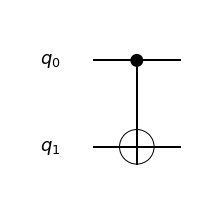

 Controlled(Y):


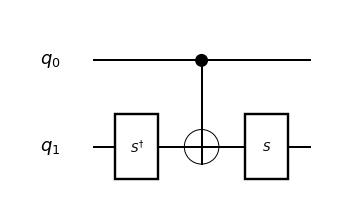

 Controlled(Z):


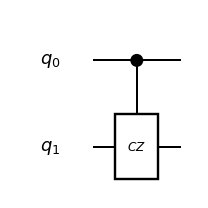

 Controlled(H):


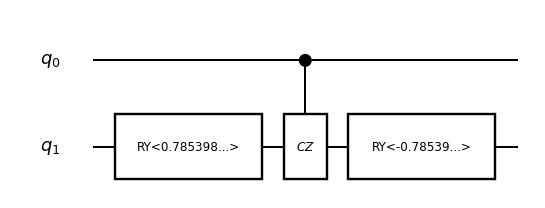

 Controlled(SqrtX):


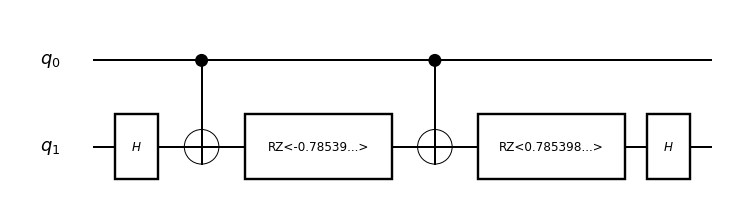

 Controlled(SqrtXdag):


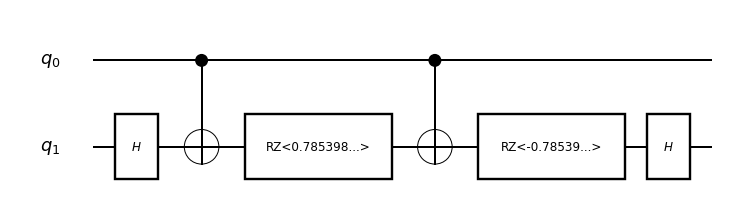

 Controlled(SqrtY):


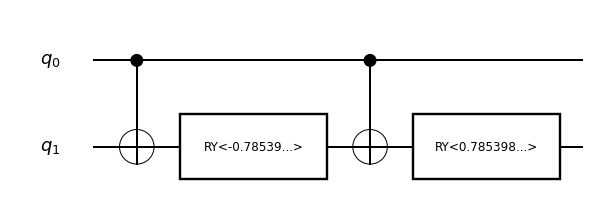

 Controlled(SqrtYdag):


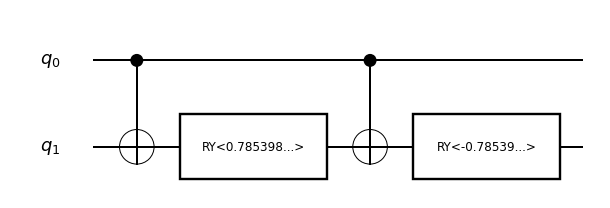

 Controlled(S):


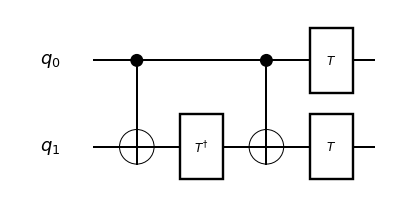

 Controlled(Sdag):


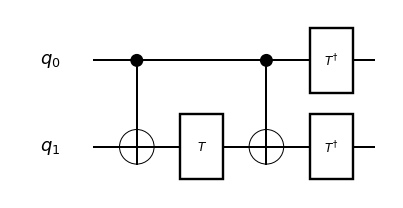

 Controlled(T):


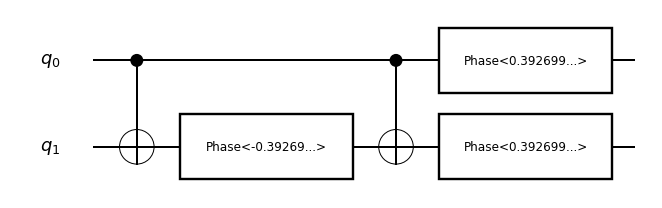

 Controlled(Tdag):


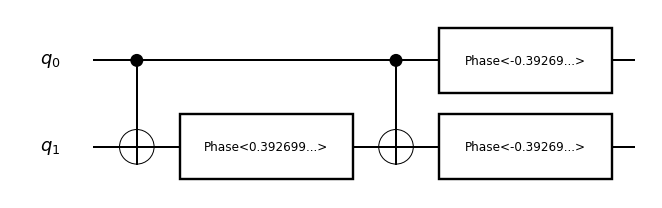

Single qubit parametric rotation gates:
 Controlled(RX(pi/8)):


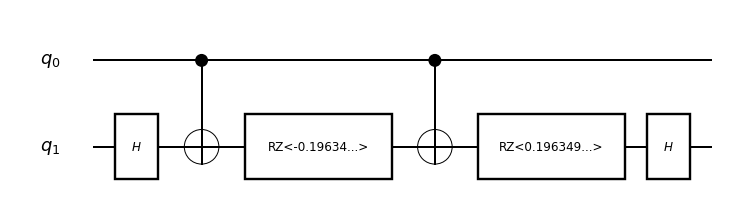

 Controlled(RY(pi/8)):


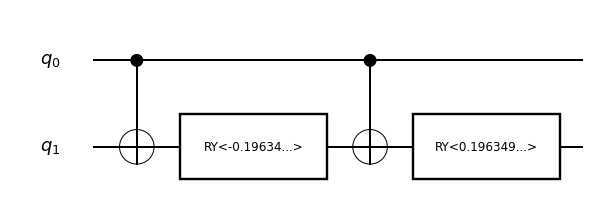

 Controlled(RZ(pi/8)):


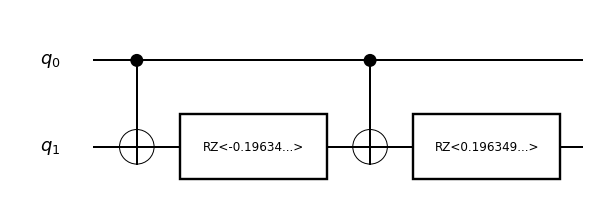

 Controlled(Phase(pi/8)):


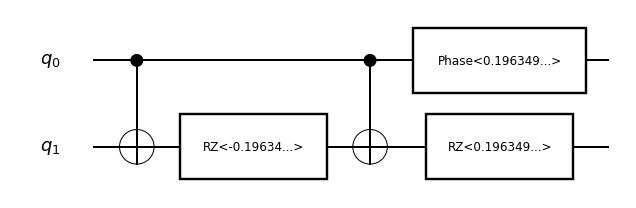

Two qubit non-parametric gates:
 Controlled(CNOT):


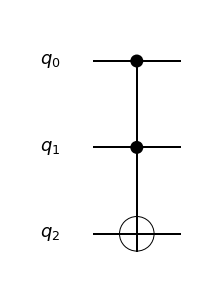

 Controlled(CZ):


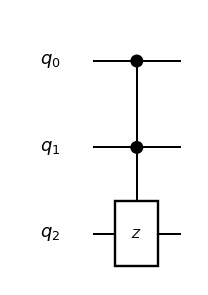

 Controlled(SWAP):


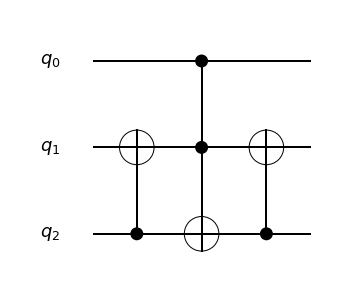

Three qubit non-parametric gates:
 Controlled(Toffoli):


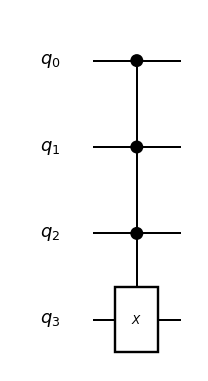

In [33]:
from math import pi
from IPython.display import display
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.visualize import draw_sub
from quri_parts.qsub.lib import std

print("Single qubit non-parametric gates:")
for op in [
    std.X,
    std.Y,
    std.Z,
    std.H,
    std.SqrtX,
    std.SqrtXdag,
    std.SqrtY,
    std.SqrtYdag,
    std.S,
    std.Sdag,
    std.T,
    std.Tdag,
]:
    ctrl = std.Controlled(op)
    ctrl_sub = resolve_sub(ctrl)
    print(f" Controlled({op.base_id[1]}):")
    display(draw_sub(ctrl_sub))

print("Single qubit parametric rotation gates:")
for op in [
    std.RX,
    std.RY,
    std.RZ,
    std.Phase,
]:
    ctrl = std.Controlled(op(pi/8))
    ctrl_sub = resolve_sub(ctrl)
    print(f" Controlled({op.base_id[1]}(pi/8)):")
    display(draw_sub(ctrl_sub))

print("Two qubit non-parametric gates:")
for op in [
    std.CNOT,
    std.CZ,
    std.SWAP,
]:
    ctrl = std.Controlled(op)
    ctrl_sub = resolve_sub(ctrl)
    print(f" Controlled({op.base_id[1]}):")
    display(draw_sub(ctrl_sub))

print("Three qubit non-parametric gates:")
ctrl = std.Controlled(std.Toffoli)
ctrl_sub = resolve_sub(ctrl)
print(f" Controlled({std.Toffoli.base_id[1]}):")
display(draw_sub(ctrl_sub))

### Resolving MultiControlled

`MultiControlled` operation is resolved using Toffoli gates by default. (An alternative way to resolve it with measurement and conditional operation is also provided, which will be mentioned elsewhere.) In this construction, if the number of control bits is $k$, then $k-1$ auxiliary qubits are added inside the resolved `Sub`.

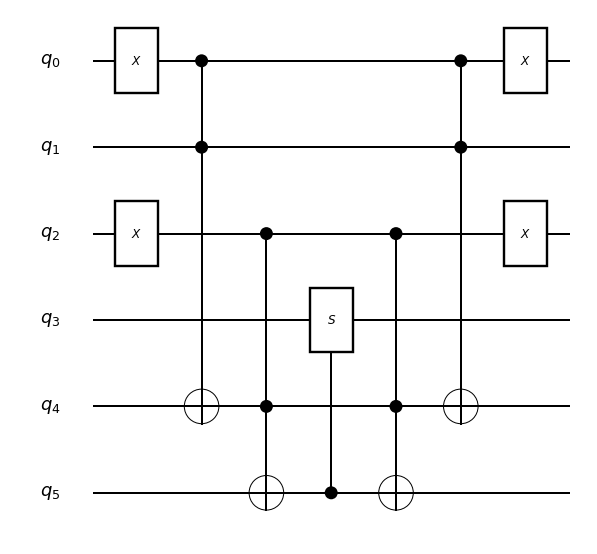

In [34]:
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.visualize import draw_sub
from quri_parts.qsub.lib import std

mctrlS = std.MultiControlled(std.S, 3, 0b010)
mctrlS_sub = resolve_sub(mctrlS)
draw_sub(mctrlS_sub)

In the above diagram, `q4` and `q5` are auxiliary qubits added inside the resolved `Sub`.

## Compile and analyze a `Sub`

By *compiling* a `Sub`, you can perform various analysis on the compiled circuit (`MachineSub`). Let's prepare a `Sub` to be compiled:

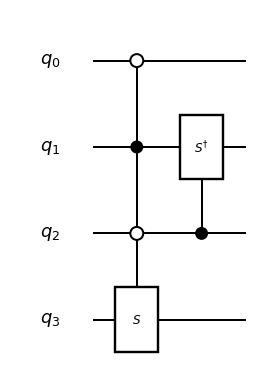

In [35]:
from quri_parts.qsub.sub import SubBuilder
from quri_parts.qsub.visualize import draw_sub
from quri_parts.qsub.lib import std

# Build a circuit for 4 qubits
b = SubBuilder(4)
q0, q1, q2, q3 = b.qubits
b.add_op(std.MultiControlled(std.S, 3, 0b010), (q0, q1, q2, q3))
b.add_op(std.Controlled(std.Sdag), (q2, q1))
sub = b.build()

draw_sub(sub)

In order to perform compilation you need to determine `primitives`, which specifies which `Op`s you want to treat as primitives (i.e. not replaced by subroutines). When you are not sure which operations to specify as primitives, you can start with a small set and add missing primitives by inspecting an error message:

In [36]:
from quri_parts.qsub.compile import compile_sub
from quri_parts.qsub.lib import std

primitives = (std.CNOT, std.Toffoli)
try:
    compiled = compile_sub(sub, primitives)
except Exception as e:
    print(e)

Op lib.std.X(qubits=1, registers=0) is not found in calltable.


The error message above tells us that `X` is missing from `primitives`. Repeating the procedure, we can come up with the following primitives for this example.

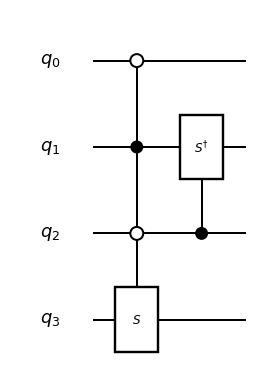

In [37]:
from quri_parts.qsub.compile import compile_sub
from quri_parts.qsub.visualize import draw_msub
from quri_parts.qsub.lib import std

primitives = (std.X, std.T, std.Tdag, std.CNOT, std.Toffoli)
compiled = compile_sub(sub, primitives)
draw_msub(compiled)

Though the circuit diagram is the same as that before the compilation, the compiled subroutine (`MachineSub`) contains additional information such as definitions of subroutines called internally.

After compilation you can perform several analyses using `Evaluator` and `EvaluatorHooks`.

### Counting gates in the circuit

You can count gates of specific types in the circuit as follows:

In [38]:
from quri_parts.qsub.evaluate import Evaluator
from quri_parts.qsub.eval import GateCountEvaluatorHooks

gate_counter = Evaluator(GateCountEvaluatorHooks((std.T, std.Tdag, std.Toffoli)))
gate_count = gate_counter.run(compiled)
print({k[1]: v for k, v in gate_count.items()})

{'Toffoli': 4, 'Tdag': 3, 'T': 3}


### Counting max number of auxiliary qubits required

Some operations (such as `MultiControlled`) use auxiliary qubits in addition to input/output qubits of the circuit. you can count the maximum number of simultaneously required auxiliary qubits as follows:

In [39]:
from quri_parts.qsub.evaluate import Evaluator
from quri_parts.qsub.eval import AuxQubitCountEvaluatorHooks

aux_counter = Evaluator(AuxQubitCountEvaluatorHooks())
aux_count = aux_counter.run(compiled)
print(f"Max # of aux qubits: {aux_count}")

Max # of aux qubits: 2


### Expand the circuit with primitives

It is possible to expand the circuit with primitives.

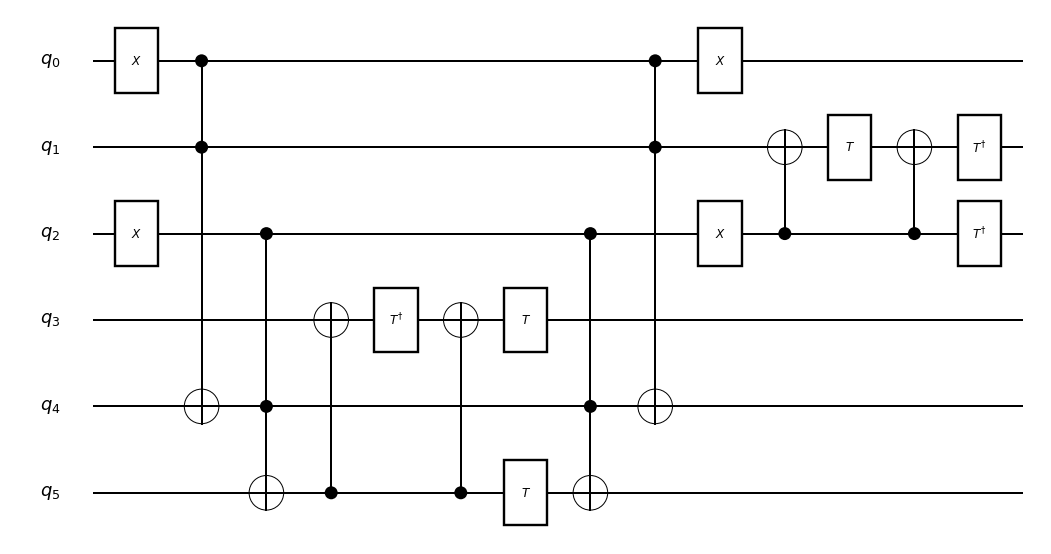

In [40]:
from quri_parts.qsub.expand import full_expand
from quri_parts.qsub.visualize import draw_msub

expanded = full_expand(compiled)
draw_msub(expanded)

### Exercise 7

Expand the circuit that you built for exercise 6 by first defining its primitives and then using the `full_expand` function

### Convert to QURI Parts circuit

You can convert the compiled subroutine to a QURI Parts circuit as follows:

In [41]:
from quri_parts.qsub.evaluate import Evaluator
from quri_parts.qsub.eval import QURIPartsEvaluatorHooks
from quri_parts.circuit.utils.circuit_drawer import draw_circuit

qp_generator = Evaluator(QURIPartsEvaluatorHooks())
qp_circuit = qp_generator.run(compiled)
draw_circuit(qp_circuit, line_length=120)

   ___                                                                             ___                          
  | X |                                                                           | X |                         
--|0  |-----●-------------------------------------------------------●-------------|11 |-------------------------
  |___|     |                                                       |             |___|                         
            |                                                       |              ___     ___     ___     ___  
            |                                                       |             |CX |   | T |   |CX |   |Tdg| 
------------●-------------------------------------------------------●-------------|13 |---|14 |---|15 |---|17 |-
            |                                                       |             |___|   |___|   |___|   |___| 
   ___      |                                                       |     ___       |           